In [1]:
pip install pymc

In [2]:
import pymc as pm
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
from scipy.special import expit as logistic
import matplotlib.pyplot as plt
import arviz as az


In [3]:
iris = pd.read_csv('iris.csv')
iris.head()


,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


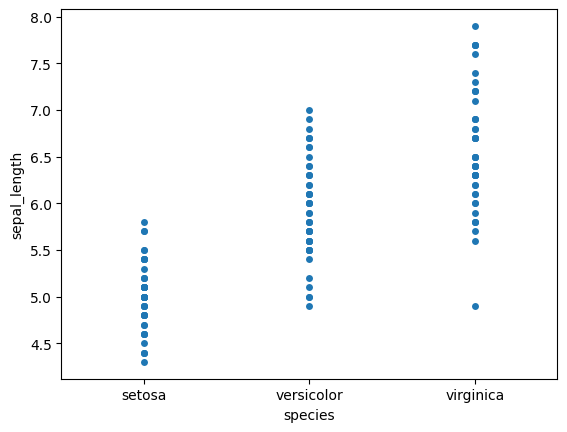

In [5]:
sns.stripplot(x="species", y="sepal_length", data=iris, jitter=False)
plt.savefig('B11197_04_02.png', dpi=300);


In [6]:
df = iris.query("species == ('setosa', 'versicolor')")
y_0 = pd.Categorical(df['species']).codes
y_0
x_n = 'sepal_length'
x_0 = df[x_n].values
# x_c = x_0 - x_0.mean()

In [7]:
with pm.Model() as model_0:
 α = pm.Normal('α', mu=0, sigma=10)
 β = pm.Normal('β', mu=0, sigma=10)

 μ = α + pm.math.dot(x_0, β)
 θ = pm.Deterministic('θ', pm.math.sigmoid(μ))
 bd = pm.Deterministic('bd', -α/β)
 yl = pm.Bernoulli('yl', p=θ, observed=y_0)
 idata_0 = pm.sample(1000, return_inferencedata=True)


In [11]:
with pm.Model() as lda:
 μ = pm.Normal('μ', mu=0, sigma=10, shape=2)
 σ = pm.HalfNormal('σ', 10)
 setosa = pm.Normal('setosa', mu=μ[0], sigma=σ, observed=x_0[:50])
 versicolor = pm.Normal('versicolor', mu=μ[1], sigma=σ, observed=x_0[50:])
 bd = pm.Deterministic('bd', (μ[0] + μ[1]) / 2)
 idata_lda = pm.sample(1000, return_inferencedata=True)

In [12]:
df=az.summary(idata_lda)
df


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
μ[0],5.008,0.066,4.880,5.132,0.001,0.001,2696.0,1337.0,1.0
μ[1],5.935,0.065,5.814,6.056,0.001,0.001,3461.0,1650.0,1.0
σ,0.448,0.032,0.385,0.506,0.001,0.000,2233.0,1243.0,1.0
bd,5.472,0.046,5.385,5.559,0.001,0.001,3374.0,1463.0,1.0


In [13]:
df.iloc[0][0]


5.008

In [14]:
df.iloc[1][0]


5.935

In [15]:
(df.iloc[0][0]+df.iloc[1][0])/2


5.4715

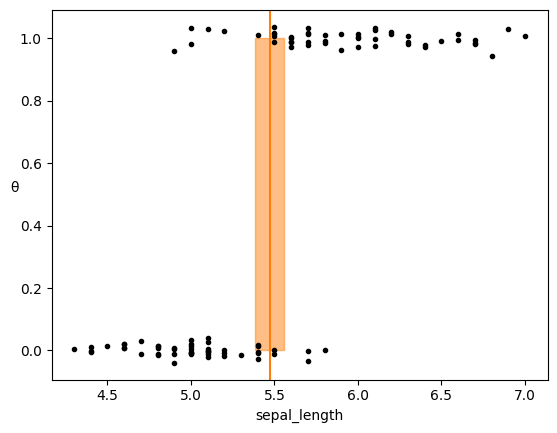

In [18]:
posterior_lda = idata_lda.posterior.stack(samples=("chain", "draw"))
plt.axvline(posterior_lda['bd'].mean(), ymax=1, color='C1')
bd_hpd = az.hdi(posterior_lda['bd'].values)
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='C1', alpha=0.5)
plt.plot(x_0, np.random.normal(y_0, 0.02), '.', color='k')
plt.ylabel('θ', rotation=0)
plt.xlabel('sepal_length')
plt.savefig('B11197_04_09.png', dpi=300)

In [19]:
n = 100
θ_real = 2.5
ϕ = 0.1
counts = np.array([(np.random.random() > (1-ϕ)) * np.random.poisson(θ_real) for i in range(n)])
counts


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 5, 0, 3, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 4, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0])

In [20]:
with pm.Model() as ZIP:
 ϕ = pm.Beta('ϕ', 1, 1)
 θ = pm.Normal('θ', 2, 0.1)
 y = pm.ZeroInflatedPoisson('y', ϕ, θ, observed=counts)
 idata = pm.sample(1000, return_inferencedata=True)


In [21]:
az.summary(idata)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
θ,2.033,0.103,1.836,2.22,0.002,0.002,1921.0,1439.0,1.0
ϕ,0.123,0.035,0.059,0.19,0.001,0.001,1789.0,1303.0,1.0


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


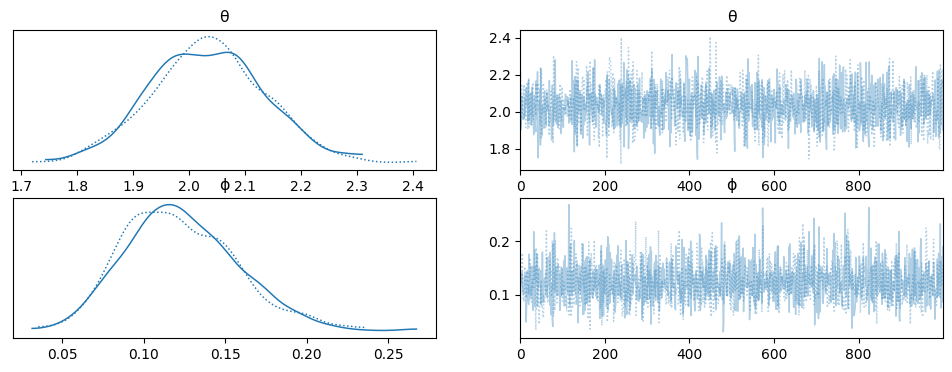

In [22]:
az.plot_trace(idata)
plt.savefig('B11197_04_11.png', dpi=300);

# Fish Dataset

In [23]:
fish_data = pd.read_csv('fish.csv')
fish_data.head(5)


,nofish,livebait,camper,persons,child,xb,zg,count
0,1,0,0,1,0,-0.896315,3.050405,0
1,0,1,1,1,0,-0.558345,1.746149,0
2,0,1,0,1,0,-0.401731,0.279939,0
3,0,1,1,2,1,-0.956298,-0.601526,0
4,0,1,0,1,0,0.436891,0.527709,1


In [24]:
fish_data['count'].value_counts()

0      142
1       31
2       20
3       12
5       10
4        6
6        4
7        3
21       2
9        2
8        2
15       2
32       2
22       1
149      1
29       1
14       1
11       1
31       1
13       1
65       1
30       1
16       1
10       1
38       1
Name: count, dtype: int64

In [27]:
fish_data = pd.read_csv("fish.csv")
with pm.Model() as ZIP_reg:

 ψ = pm.Beta('ψ', 1, 1)
 α = pm.Normal('α', 0, 10)
 β = pm.Normal('β', 0, 10, shape=2)
 θ = pm.math.exp(α + β[0] * fish_data['child'] + β[1] * fish_data['camper'])
 yl = pm.ZeroInflatedPoisson('yl', ψ, θ, observed=fish_data['count'])
 idata_ZIP_reg = pm.sample(1000, return_inferencedata=True)

In [28]:
az.summary(idata_ZIP_reg)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,1.614,0.091,1.444,1.785,0.003,0.002,1002.0,1087.0,1.0
β[0],-0.931,0.094,-1.093,-0.750,0.003,0.002,1246.0,1309.0,1.0
β[1],0.805,0.097,0.622,0.992,0.003,0.002,996.0,1117.0,1.0
ψ,0.486,0.035,0.423,0.554,0.001,0.001,1653.0,1013.0,1.0


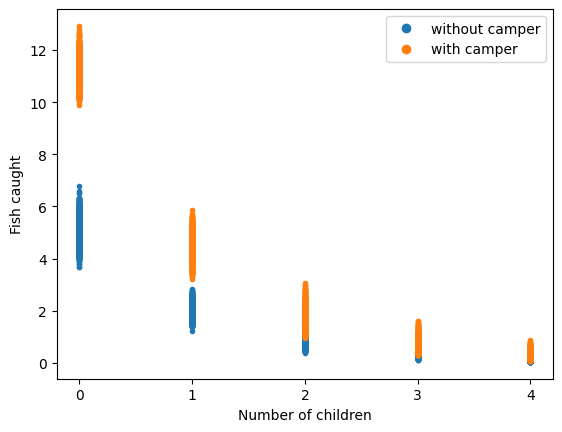

In [31]:
children = [0, 1, 2, 3, 4]
fish_count_pred_0 = []
fish_count_pred_1 = []
posterior_ZIP_reg = idata_ZIP_reg.posterior.stack(samples=("chain", "draw"))

for n in children:
    without_camper = posterior_ZIP_reg['α'] + \
                      posterior_ZIP_reg['β'].values[0] * n
    with_camper = without_camper + posterior_ZIP_reg['β'].values[1]
    fish_count_pred_0.append(np.exp(without_camper))
    fish_count_pred_1.append(np.exp(with_camper))

plt.plot(children, fish_count_pred_0, 'C0.')
plt.plot(children, fish_count_pred_1, 'C1.')
plt.xticks(children)
plt.xlabel('Number of children')
plt.ylabel('Fish caught')
plt.plot([], 'C0o', label='without camper')
plt.plot([], 'C1o', label='with camper')
plt.legend()
plt.savefig('B11197_04_12.png', dpi=300)


In [32]:
iris = sns.load_dataset("iris")
df = iris.query("species == ('setosa', 'versicolor')")
y_0 = pd.Categorical(df['species']).codes


In [33]:
y_0

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int8)

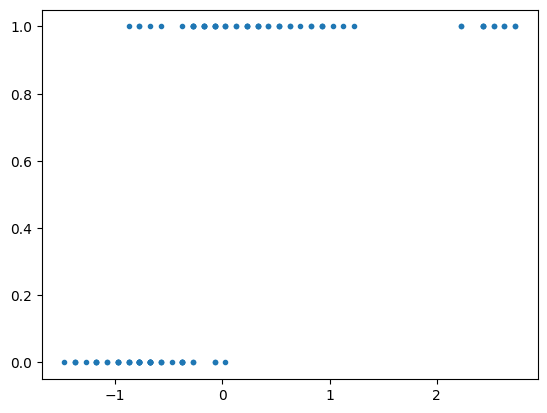

In [34]:
x_n = 'sepal_length'
x_0 = df[x_n].values
y_0 = np.concatenate((y_0, np.ones(12, dtype=int)))
# y_0 = np.concatenate((y_0, np.zeros(12, dtype=int)))
x_0 = np.concatenate((x_0, [8.2, 8.5, 8.0, 8.3, 8.2, 8.4,8.2, 8.5, 8.0,
8.3, 8.2, 8.4]))
x_c = x_0 - x_0.mean()
plt.plot(x_c, y_0, '.');


In [36]:
with pm.Model() as model_rlg:
 α = pm.Normal('α', mu=0, sigma=10)
 β = pm.Normal('β', mu=0, sigma=10)

 μ = α + x_c * β
 θ = pm.Deterministic('θ', pm.math.sigmoid(μ))
 bd = pm.Deterministic('bd', -α/β)

 π = pm.Beta('π', 1., 1.)
 p = π * 0.5 + (1 - π) * θ

 yl = pm.Bernoulli('yl', p=p, observed=y_0)
 idata_rlg = pm.sample(1000, target_accept=0.95,
return_inferencedata=True)


In [37]:
varnames = ['α', 'β', 'bd','π']


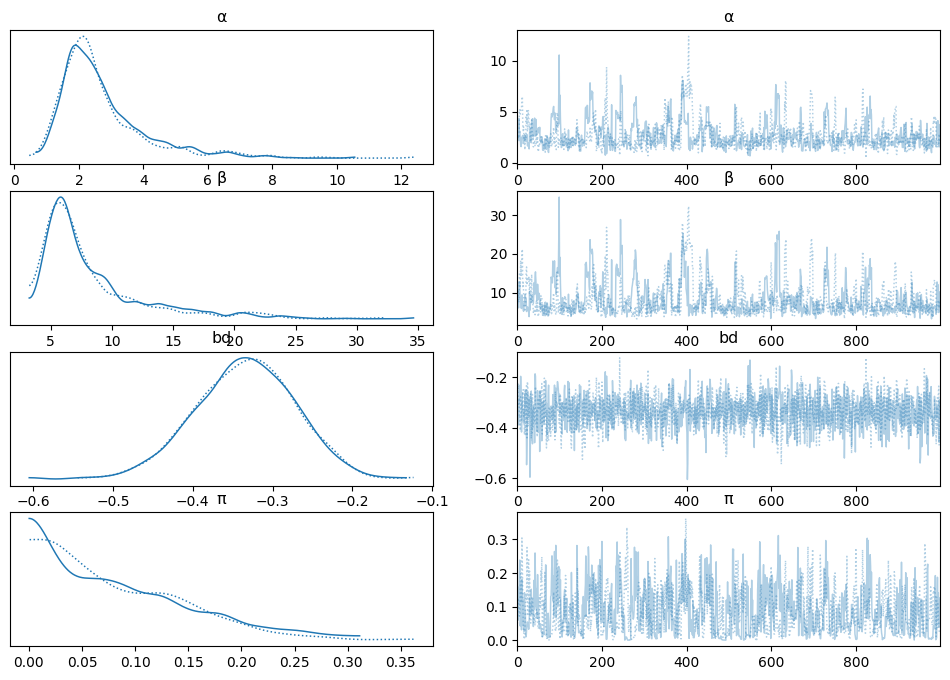

In [38]:
az.plot_trace(idata_rlg, varnames);


In [39]:
az.summary(idata_rlg, varnames)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
α,2.702,1.352,0.940,5.382,0.093,0.069,290.0,233.0,1.02
β,8.260,4.372,3.230,16.994,0.304,0.222,287.0,236.0,1.01
bd,-0.335,0.063,-0.453,-0.221,0.002,0.001,1498.0,1325.0,1.00
π,0.086,0.068,0.000,0.209,0.003,0.002,336.0,373.0,1.01
